# How do Central Defenders Contribute to the Build Up Play?

In [1164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontManager
import plotly.express as px
from PIL import Image
from scipy import stats
import math
from sklearn.cluster import KMeans

from adjustText import adjust_text

from urllib.request import urlopen

from mplsoccer import Pitch, VerticalPitch, FontManager

import requests
from bs4 import BeautifulSoup
from selenium import webdriver

In [329]:
cb = pd.read_csv('center-backs.csv')

In [2107]:
standardStats = pd.read_html('https://fbref.com/en/share/ngXpf', header=1)[0]
standardStats = standardStats[['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', '90s']]
standardStats = standardStats.drop_duplicates(['Player'])

passingStats = pd.read_html('https://fbref.com/en/share/UvyXJ', header=1)[0]
passingStats = passingStats[['Player', 'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', '1/3', 'PPA', 'CrsPA', 'Prog']]
passingStats = passingStats.drop_duplicates(['Player'])

possessionStats = pd.read_html('https://fbref.com/en/share/kB0pM', header=1)[0]
possessionStats = possessionStats[['Player', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Carries', 'TotDist', 'PrgDist', 'Prog', 'Mis', 'Dis']]
possessionStats = possessionStats.drop_duplicates(['Player'])

miscStats = pd.read_html('https://fbref.com/en/share/wUvM6', header=1)[0]
miscStats = miscStats[['Player', 'Fls', 'Won', 'Won%']]
miscStats.drop_duplicates(['Player'])
miscStats = miscStats[miscStats['Player'] != 'Player']
miscStats = miscStats.fillna(value=0)
miscStats[['Fls', 'Won', 'Won%']] = miscStats[['Fls', 'Won', 'Won%']].astype('float')

defStats = pd.read_html('https://fbref.com/en/share/m2Krr', header=1)[0]
defStats = defStats[['Player', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Def 3rd.1', 'Mid 3rd.1', 'Att 3rd.1', 'Tkl', 'Tkl%', 'Int', 'Press']]
defStats = defStats.drop_duplicates(['Player'])
defStats = defStats[defStats['Player'] != 'Player']
defStats[['Def 3rd', 'Mid 3rd', 'Att 3rd', 'Def 3rd.1', 'Mid 3rd.1', 'Att 3rd.1', 'Tkl', 'Tkl%', 'Int', 'Press']] = defStats[['Def 3rd', 'Mid 3rd', 'Att 3rd', 'Def 3rd.1', 'Mid 3rd.1', 'Att 3rd.1', 'Tkl', 'Tkl%', 'Int', 'Press']].astype('float')
defStats['Def 3rd DA'] = defStats['Def 3rd'] + defStats['Def 3rd.1']
defStats['Mid 3rd DA'] = defStats['Mid 3rd'] + defStats['Mid 3rd.1']
defStats['Att 3rd DA'] = defStats['Att 3rd'] + defStats['Att 3rd.1']
defStats = defStats[['Player', 'Def 3rd DA', 'Mid 3rd DA', 'Att 3rd DA', 'Tkl', 'Tkl%', 'Int', 'Press']]
defStats = defStats.fillna(value=0)

teamStats = pd.read_html('https://fbref.com/en/share/nHHQW', header=1)[0]
teamStats = teamStats[['Squad', 'SoT']]

In [2108]:
bplPassing = pd.read_html('https://fbref.com/en/share/XPG4t', header=1)[0]
bplPassing['NR'] = bplPassing['Cmp'].mean() / bplPassing['Cmp']
bplPassing = bplPassing[['Squad', 'Cmp', 'Prog', 'NR']]

laligaPassing = pd.read_html('https://fbref.com/en/share/FR4JG', header=1)[0]
laligaPassing['NR'] = laligaPassing['Cmp'].mean() / laligaPassing['Cmp']
laligaPassing = laligaPassing[['Squad', 'Cmp', 'Prog', 'NR']]

bundesligaPassing = pd.read_html('https://fbref.com/en/share/PLOV1', header=1)[0]
bundesligaPassing['NR'] = bundesligaPassing['Cmp'].mean() / bundesligaPassing['Cmp']
bundesligaPassing = bundesligaPassing[['Squad', 'Cmp', 'Prog', 'NR']]

serieaPassing = pd.read_html('https://fbref.com/en/share/Yl7YH', header=1)[0]
serieaPassing['NR'] = serieaPassing['Cmp'].mean() / serieaPassing['Cmp']
serieaPassing = serieaPassing[['Squad', 'Cmp', 'Prog', 'NR']]

ligue1Passing = pd.read_html('https://fbref.com/en/share/WI7XP', header=1)[0]
ligue1Passing['NR'] = ligue1Passing['Cmp'].mean() / ligue1Passing['Cmp']
ligue1Passing = ligue1Passing[['Squad', 'Cmp', 'Prog', 'NR']]

In [2109]:
normRatios = pd.concat([bplPassing, laligaPassing, bundesligaPassing, serieaPassing, ligue1Passing]).reset_index()
dfNR = normRatios[['Squad', 'NR']]

In [2110]:
topFive = pd.read_html('https://fbref.com/en/share/qdwUL', header=1)[0]
topFive = topFive[['Squad', 'Touches']]
topFive = topFive.rename({'Touches': 'TeamTouches'}, axis=1)

In [2111]:
df = pd.merge(standardStats, passingStats, on='Player', how='outer')
df = pd.merge(df, possessionStats, on='Player', how='outer')
df = pd.merge(df, teamStats, on='Squad', how='outer')
df = pd.merge(df, dfNR, on='Squad', how='outer')
df = pd.merge(df, topFive, on='Squad', how='outer')
df = pd.merge(df, defStats, on='Player', how='outer')

In [2112]:
df = df.rename({'TotDist_x': 'TotDisPass',
                'PrgDist_x': 'PrgDistPass',
                'Prog_x': 'ProgPass',
                'TotDist_y': 'TotDistCarry',
                'PrgDist_y': 'PrgDistCarry',
                'Prog_y': 'ProgCarry'}, axis=1)

In [2113]:
df['Nation'] = df['Nation'].str.split(' ').str[1]
df['Comp1'] = df['Comp'].str.split(' ').str[1]
df['Comp2'] = df['Comp'].str.split(' ').str[2]
df['Comp'] = df['Comp1'] + " " + df['Comp2']
df = df.drop(['Comp1', 'Comp2'], axis=1)

In [2114]:
df = df[df['90s'] != '90s']

In [2115]:
df[['90s', 'Cmp', 'Att', 'Cmp%', 'TotDisPass', 'PrgDistPass', '1/3', 'PPA', 'CrsPA', 'ProgPass', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Carries', 'TotDistCarry', 'PrgDistCarry', 'ProgCarry', 'Mis', 'Dis', 'NR']] = df[['90s', 'Cmp', 'Att', 'Cmp%', 'TotDisPass', 'PrgDistPass', '1/3', 'PPA', 'CrsPA', 'ProgPass', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Carries', 'TotDistCarry', 'PrgDistCarry', 'ProgCarry', 'Mis', 'Dis', 'NR']].astype('float')

In [2116]:
df.Comp = df.Comp.fillna('Bundesliga')

In [2117]:
len(df)

2630

In [2118]:
df = df.dropna()

In [2119]:
df['normProg'] = round(df['ProgPass'] * df['NR'],2)

In [2120]:
df['shareTouches'] = round((df['Touches'] / df['TeamTouches'])*100,2)

In [2121]:
df.to_csv('df.csv')

In [2122]:
df = df[df['90s'] > 15]

### Metrics to Measure Ability of Center Backs to Contribute to Buildup Play
1. Progressive Passes (Nomralise?)
2. Progressive Carries (Normalise?)
3. Share of touches in def/mid/att thirds out of total team touches
4. Progressive passes per touches on the ball
5. Progressive passes per pass attempted/completed
6. Pass completion % total / short / medium / long
7. Number of times player was a target of pass
8. Number of times player successfully recieved pass
9. recieved pass per times was target of pass
10. touches per shot
11. passes per shot
12. progressive passes per shot
13. xGXhain / xGBuildup

### Possession Oriented Defender - American Soccer Analysis
A central Defender who's on-ball actions often progress the ball and often defends higher up the pitch in the middle third

In [2123]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

In [2124]:
df = df[df['Pos'] == 'DF']

In [2125]:
df = pd.merge(df, miscStats, on='Player', how='outer')

In [2126]:
df = df.dropna()

In [2127]:
df['Mid 3rd DA%'] = df['Mid 3rd'] / (df['Def 3rd DA'] + df['Mid 3rd DA'] + df['Att 3rd DA'])
df['Att 3rd DA%'] = df['Att 3rd'] / (df['Def 3rd DA'] + df['Mid 3rd DA'] + df['Att 3rd DA'])
df['Def 3rd DA%'] = df['Def 3rd'] / (df['Def 3rd DA'] + df['Mid 3rd DA'] + df['Att 3rd DA'])

In [2128]:
df['Def 3rd Ratio'] = round(df['Def 3rd DA'] / (df['Mid 3rd DA'] + 0.000000000001),2)
df['Mid 3rd Ratio'] = round(1 / (df['Def 3rd Ratio'] + 0.000000000001),2)

In [2129]:
df['ProgActions'] = df['ProgCarry'] + df['normProg']

In [2130]:
df = df[['Player', 'Comp', '90s', 'Cmp%', 'PrgDistPass', 'normProg', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
         'Att Pen', 'ProgCarry', 'PrgDistCarry', 'Mis', 'Dis', 'shareTouches', 'Def 3rd DA%', 'Mid 3rd DA%', 'Att 3rd DA%',
         'ProgActions', 'Def 3rd Ratio', 'Mid 3rd Ratio', 'Tkl', 'Tkl%', 'Int', 'Press', 'Fls', 'Won', 'Won%']]

In [2131]:
model_df = df

In [2132]:
len(df)

255

In [2133]:
model_df['Share of Total Team Touches'] = pd.qcut(df['shareTouches'], np.linspace(0,1,91), labels=np.linspace(0.01,1,90))
model_df['Progressive Actions'] = pd.qcut(df.ProgActions, np.linspace(0,1,101), labels=np.linspace(0.01,1,100))
model_df['% of Defensive Actions in Middle 3rd'] = pd.qcut(df['Mid 3rd DA%'], np.linspace(0,1,101), labels=np.linspace(0.01,1,100))
model_df['Def Pen Percentile'] = pd.qcut(df['Def Pen'], np.linspace(0,1,101), labels=np.linspace(0.01,1,100))

In [2134]:
model_df = model_df[['Player', 'Comp', 'Share of Total Team Touches', 'Progressive Actions', '% of Defensive Actions in Middle 3rd', 'Def Pen Percentile']]
params = model_df.drop(['Player', 'Comp'], axis=1)

In [2135]:
# implement kmeans algorithm
X = np.array(params)
kmeans = KMeans(n_clusters=3, random_state=100)
kmeans.fit(X)
model_df['cluster'] = kmeans.predict(X)

In [2136]:
fig = px.scatter_ternary(model_df, a='Share of Total Team Touches', b='Progressive Actions', c='% of Defensive Actions in Middle 3rd', 
                         title='Triangular Play Style Plot: Defenders',
                         color='cluster', size_max=15, hover_name='Player',
                         size='Progressive Actions')
fig.show()

In [2137]:
clusters = model_df[['Player', 'cluster']]
df = pd.merge(df, clusters, on='Player', how='outer')

In [2138]:
center_backs = df[df['cluster'] == 2]

In [2139]:
center_backs['% of Defensive Actions in Defensive 3rd'] = pd.qcut(center_backs['Def 3rd DA%'], np.linspace(0,1,101), labels=np.linspace(0.01,1,100))
center_backs['Progressive Actions'] = pd.qcut(center_backs.ProgActions, np.linspace(0,1,101), labels=np.linspace(0.01,1,100))
center_backs['% of Defensive Actions in Middle 3rd'] = pd.qcut(center_backs['Mid 3rd DA%'], np.linspace(0,1,101), labels=np.linspace(0.01,1,100))

In [2140]:
center_backs = center_backs[['Player', 'Comp', 'cluster', 'Progressive Actions', '% of Defensive Actions in Middle 3rd']]
params = center_backs.drop(['Player', 'Comp', 'cluster'], axis=1)

In [2141]:
X = np.array(params)
kmeans = KMeans(n_clusters=4, random_state=100)
kmeans.fit(X)
center_backs['Role'] = kmeans.predict(X)
center_backs.Role.value_counts()

3    23
1    21
2    18
0    13
Name: Role, dtype: int64

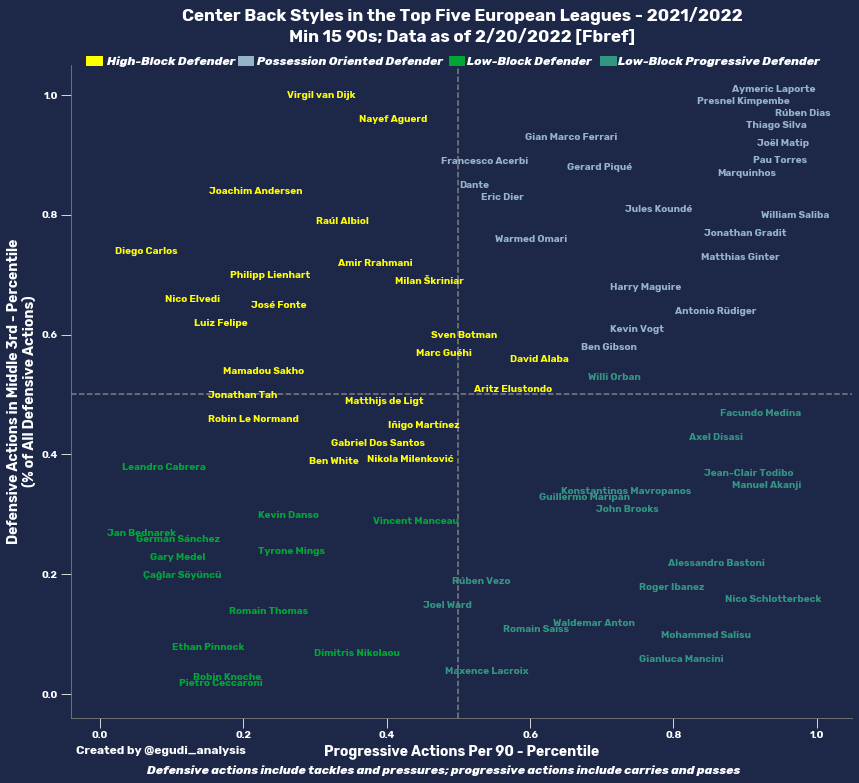

In [2142]:
role1 = center_backs[center_backs['Role'] == 0]
role2 = center_backs[center_backs['Role'] == 1]
role3 = center_backs[center_backs['Role'] == 2]
role4 = center_backs[center_backs['Role'] == 3]

Rubik = FontManager('https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Bold.ttf?raw=true')
Rubik_italic = FontManager('https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-ExtraBoldItalic.ttf?raw=true')

x = center_backs['Progressive Actions']
y = center_backs['% of Defensive Actions in Middle 3rd']

x1 = role1['Progressive Actions']
y1 = role1['% of Defensive Actions in Middle 3rd']
x2 = role2['Progressive Actions']
y2 = role2['% of Defensive Actions in Middle 3rd']
x3 = role3['Progressive Actions']
y3 = role3['% of Defensive Actions in Middle 3rd']
x4 = role4['Progressive Actions']
y4 = role4['% of Defensive Actions in Middle 3rd']

plt.rcParams['axes.edgecolor'] = 'gray'

fig, ax = plt.subplots(figsize=(14, 12))
fig.set_facecolor('#1d2849')
ax.set_facecolor('#1d2849')

def plot_players(adjust=False, *args, **kwargs):
    plt.scatter(x1, y1, s=15, c='#1d2849')
    texts = []
    for x, y, s in zip(x1, y1, role1['Player']):
        texts.append(plt.text(x, y, s, size=10, fontproperties=Rubik.prop, color='#00a737'))
    if adjust:
        plt.title('%s iterations' % adjust_text(texts, force_text=0.05,
                                                save_steps=True, **kwargs))
        
plot_players(adjust=True)

def plot_players3(adjust=False, *args, **kwargs):
    plt.scatter(x3, y3, s=15, c='#1d2849')
    texts = []
    for x, y, s in zip(x3, y3, role3['Player']):
        texts.append(plt.text(x, y, s, size=10, fontproperties=Rubik.prop, color='#329682'))
    if adjust:
        plt.title('%s iterations' % adjust_text(texts, precision=0.01,
                                                save_steps=True, **kwargs))
        
plot_players3(adjust=True)

def plot_players2(adjust=False, *args, **kwargs):
    plt.scatter(x2, y2, s=15, c='#1d2849')
    texts = []
    for x, y, s in zip(x2, y2, role2['Player']):
        texts.append(plt.text(x, y, s, size=10, fontproperties=Rubik.prop, color='#96b4c8'))
    if adjust:
        plt.title('%s iterations' % adjust_text(texts, precision=0.01,
                                                save_steps=True, **kwargs))
        
plot_players2(adjust=True)

def plot_players4(adjust=False, *args, **kwargs):
    plt.scatter(x4, y4, s=15, c='#1d2849')
    texts = []
    for x, y, s in zip(x4, y4, role4['Player']):
        texts.append(plt.text(x, y, s, size=10, fontproperties=Rubik.prop, color='yellow'))
    if adjust:
        plt.title('%s iterations' % adjust_text(texts, precision=0.01,
                                                save_steps=True, **kwargs))
        
plot_players4(adjust=True)
    
ax.set_title('Center Back Styles in the Top Five European Leagues - 2021/2022\nMin 15 90s; Data as of 2/20/2022 [Fbref]\n',
             color='white', fontproperties=Rubik.prop, size=17)
ax.set_xlabel('Progressive Actions Per 90 - Percentile', color='white', fontproperties=Rubik.prop, size=14)
ax.set_ylabel('Defensive Actions in Middle 3rd - Percentile\n(% of All Defensive Actions)', color='white',
              fontproperties=Rubik.prop, size=14);
ax.axhline(y=0.5, linestyle='--', color='gray')
ax.axvline(x=0.5, linestyle='--', color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', colors='white', size=10)
ax.tick_params(axis='y', colors='white', size=10)

for label in ax.get_xticklabels():
    label.set_fontproperties(Rubik.prop)

for label in ax.get_yticklabels():
    label.set_fontproperties(Rubik.prop)
    
fig.text(
    0.16, 0.88, 'High-Block Defender         Possession Oriented Defender          Low-Block Defender           Low-Block Progressive Defender', size=12,
    fontproperties=Rubik_italic.prop, color='white')
    
# add rectangles
fig.patches.extend([
    plt.Rectangle(
     (0.14, 0.88), 0.015, 0.011, fill=True, color='yellow',
     transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
    (0.29, 0.88), 0.015, 0.011, fill=True, color='#96b4c8',
    transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
    (0.5, 0.88), 0.015, 0.011, fill=True, color='#00a737',
    transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
    (0.65, 0.88), 0.015, 0.011, fill=True, color='#329682',
    transform=fig.transFigure, figure=fig
    )
])

fig.text(0.13, 0.083,'Created by @egudi_analysis', size=12, color='white', fontproperties=Rubik.prop);
fig.text(0.2, 0.06,'Defensive actions include tackles and pressures; progressive actions include carries and passes'
         , size=12, color='white', fontproperties=Rubik_italic.prop);

plt.savefig('center-back-styles.png')

## Center-Back Possession Oriented Profile

### Metrics
1. Passing % - Y
2. Pressures - Y
3. Fouls - Y
4. Tackle % - Y
5. padj Tackles - y
6. padj Interceptions - y
7. Aerials Won - Y
8. Aerial Win % - Y
9. Progressive Actions - Y
10. Defensive Actions in Middle 3rd % - Y

In [2081]:
cb_template = df[['Player', 'Cmp%', 'Press', 'Fls', 'Tkl%', 'Tkl', 'Int', 'Won', 'Won%', 'ProgActions', 'Def 3rd DA%']]
pau_torres = cb_template[cb_template['Player'] == 'Pau Torres']
gerard_pique = cb_template[cb_template['Player'] == 'Gerard Piqué']

In [2103]:
villareal = pd.read_html('https://fbref.com/en/share/stArB', header=1)[0]
villareal = villareal[['Date', 'Poss']]
pau = pd.read_html('https://fbref.com/en/share/lYtAr', header=1)[0]
pau = pau[['Date', 'Min', 'Tkl', 'Int']]
pau = pau.fillna(value=0)
pau = pd.merge(pau, villareal, on='Date', how='outer')
pau = pau[['Date', 'Min', 'Poss', 'Tkl', 'Int']]
pau = pau.dropna(axis=0)
pau = pau[pau['Date'] != 'Date']
pau[['Min', 'Poss', 'Tkl', 'Int']] = pau[['Min', 'Poss', 'Tkl', 'Int']].astype('float')
pau['padjTkl'] = (0.5 / ((100 - pau.Poss) / 100) * pau.Tkl)
pau['padjInt'] = (0.5 / ((100 - pau.Poss) / 100) * pau.Int)
pau_torres['padjTkls'] = round((pau.padjTkl).sum() / (pau.Min.sum() / 90),2)
pau_torres['padjInt'] = round((pau.padjInt).sum() / (pau.Min.sum() / 90),2)

barca = pd.read_html('https://fbref.com/en/share/lii6n', header=0)[0]
barca = barca[['Date', 'Poss']]
pique = pd.read_html('https://fbref.com/en/share/Wp3Cx', header=1)[0]
pique = pique[['Date', 'Min', 'Tkl', 'Int']]
pique = pique.fillna(value=0)
pique = pd.merge(pique, barca, on='Date', how='outer')
pique = pique[['Date', 'Min', 'Poss', 'Tkl', 'Int']]
pique = pique.dropna(axis=0)
pique = pique[pique['Date'] != 'Date']
pique[['Min', 'Poss', 'Tkl', 'Int']] = pique[['Min', 'Poss', 'Tkl', 'Int']].astype('float')
pique['padjInt'] = (0.5 / ((100 - pique.Poss) / 100) * pau.Int)
pique['padjTkl'] = (0.5 / ((100 - pique.Poss) / 100) * pau.Tkl)
gerard_pique['padjTkls'] = round((pique.padjTkl).sum() / (pique.Min.sum() / 90),2)
gerard_pique['padjInt'] = round((pique.padjInt).sum() / (pique.Min.sum() / 90),2)

In [2104]:
pau_torres = pau_torres[['Player', 'Cmp%', 'Press', 'Fls', 'Tkl%', 'padjTkls', 'padjInt', 'Won', 'Won%', 'ProgActions', 'Def 3rd DA%']]
gerard_pique = gerard_pique[['Player', 'Cmp%', 'Press', 'Fls', 'Tkl%', 'padjTkls', 'padjInt', 'Won', 'Won%', 'ProgActions', 'Def 3rd DA%']]